# Project: Home Credit Default Risk
Jian Xu, Tao Peng, Yuanlong Gu, Jinhua Xu

## Import libraries

In [1]:
%%capture
import numpy as np 
import pandas as pd 
import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()


## Read data

In [47]:
app_train = pd.read_csv('../all/application_train.csv')
app_test = pd.read_csv('../all/application_test.csv')

In [3]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


** According to some posters in kernel, the columns EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 are most important. **

In [50]:
app_train_ext = app_train[['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'TARGET']]
app_test_ext = app_test[['SK_ID_CURR', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

In [51]:
app_train_ext.head(3)

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,100002,0.083037,0.262949,0.139376,1
1,100003,0.311267,0.622246,NaN,0
2,100004,NaN,0.555912,0.729567,0


In [52]:
app_test_ext.head(3)

,SK_ID_CURR,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100001,0.752614,0.789654,0.159520
1,100005,0.564990,0.291656,0.432962
2,100013,NaN,0.699787,0.610991


In [17]:
ext_source_cols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

## Visualize data

In [18]:
def plot_histograms(df, cols):
    for col in cols:
        df.hist(column = col, bins = 100)    

In [19]:
#plot_histograms(app_train_ext, ext_source_cols)

## Process missing data
** At this moment, let us start with simply replacing missing data by 0.**

In [20]:
def missing_values(df, cols):
    for col in cols:
        num_missing_values = df[col].isnull().sum()
        num_rows = len(df)
        percentage_missing_values = 100 * num_missing_values / float(num_rows)
        print('Percentage of missing values in column {0} = {1} / {2} = {3}%'.format(col, num_missing_values, num_rows, percentage_missing_values))

** Percentage of missing values among all the rows: **

In [21]:
missing_values(app_train_ext, ext_source_cols)

Percentage of missing values in column EXT_SOURCE_1 = 173378 / 307511 = 56.381072547%
Percentage of missing values in column EXT_SOURCE_2 = 660 / 307511 = 0.214626468647%
Percentage of missing values in column EXT_SOURCE_3 = 60965 / 307511 = 19.8253070622%


** After filling missing values by 0: **

In [22]:
app_train_ext_fillna = app_train_ext.fillna(0.0)
missing_values(app_train_ext_fillna, ext_source_cols)

Percentage of missing values in column EXT_SOURCE_1 = 0 / 307511 = 0.0%
Percentage of missing values in column EXT_SOURCE_2 = 0 / 307511 = 0.0%
Percentage of missing values in column EXT_SOURCE_3 = 0 / 307511 = 0.0%


** Filling missing values with 0 introduces too many 0 values **

** Now remove missing data **

In [53]:
app_train_ext_removed_nan = app_train_ext.dropna(subset = ext_source_cols)
app_test_ext_removed_nan = app_test_ext.dropna(subset = ext_source_cols)

In [24]:
missing_values(app_train_ext_removed_nan, ext_source_cols)

Percentage of missing values in column EXT_SOURCE_1 = 0 / 109589 = 0.0%
Percentage of missing values in column EXT_SOURCE_2 = 0 / 109589 = 0.0%
Percentage of missing values in column EXT_SOURCE_3 = 0 / 109589 = 0.0%


In [54]:
missing_values(app_test_ext_removed_nan, ext_source_cols)

Percentage of missing values in column EXT_SOURCE_1 = 0 / 23584 = 0.0%
Percentage of missing values in column EXT_SOURCE_2 = 0 / 23584 = 0.0%
Percentage of missing values in column EXT_SOURCE_3 = 0 / 23584 = 0.0%


### Train model (logistic regression)

In [55]:
x_train = app_train_ext_removed_nan[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
y_train = app_train_ext_removed_nan[['TARGET']]
x_test = app_test_ext_removed_nan

In [56]:
# Normlaize
def normalize(df, cols):
    res = {} #Empty dictionary
    
    for col in cols:
        df_col = df[col]
        max = df_col.max()
        df_col_norm = df_col / max
        res[col] = df_col_norm
    
    res_df = pd.DataFrame(data = res) # Converts dictionary to DataFrame
    
    return res_df

In [57]:
x_train_norm = normalize(x_train, ext_source_cols)
x_test_norm = normalize(x_test, ext_source_cols)

In [61]:
x_train_norm.head(3)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.086255,0.307542,0.157014
6,0.804786,0.846784,0.554331
8,0.610095,0.240640,0.846856


In [62]:
x_test_norm.head(3)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0.807457,0.923573,0.180752
1,0.606161,0.341118,0.490591
3,0.564044,0.596114,0.694259


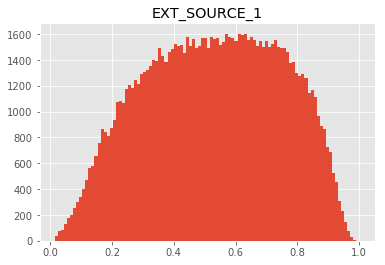

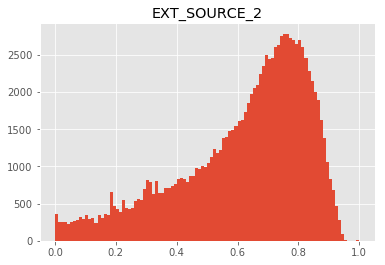

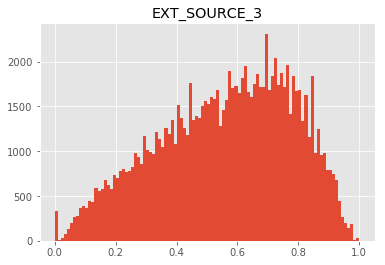

In [45]:
plot_histograms(x_train_norm, ext_source_cols)

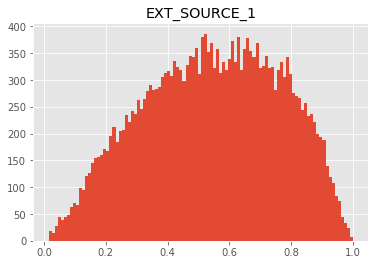

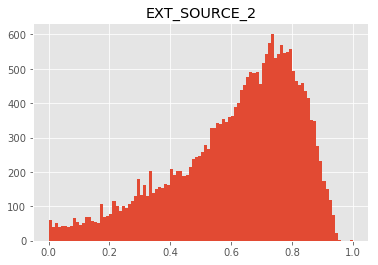

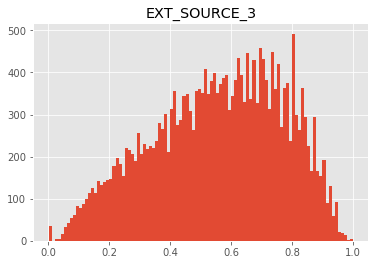

In [58]:
plot_histograms(x_test_norm, ext_source_cols)

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(x_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Make prediction on test data

In [63]:
y_pred = logreg.predict(x_test_norm)

In [66]:
logreg_prediction = logreg.predict_proba(x_test_norm)[:, 1]

In [70]:
logreg_prediction

array([ 0.04625435,  0.08263144,  0.03731078, ...,  0.12461741,
        0.04636646,  0.0602508 ])

### Todo: submit the prediction to kaggle and see the accuracy (we do not have target column in the test dataset).